In [40]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.8,)
%matplotlib inline
fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/fake-figs"

log_loc = os.path.abspath("/Users/crankshaw/clipper/experiments_logs/straggler_mitigation")

results_files = []
for name in os.listdir(log_loc):
    if "results" in name:
        results_files.append(name)

exp_names = [f.split("_results")[0] for f in results_files]
# print exp_names
print results_files

['ensemble_size_10_160914-004737_results.json', 'ensemble_size_10_trial_1_160914-102500_results.json', 'ensemble_size_10_trial_2_160914-105924_results.json', 'ensemble_size_10_trial_3_160914-113336_results.json', 'ensemble_size_10_trial_4_160914-120719_results.json', 'ensemble_size_10_trial_5_160914-124133_results.json', 'ensemble_size_12_160914-005036_results.json', 'ensemble_size_12_trial_1_160914-102800_results.json', 'ensemble_size_12_trial_2_160914-110225_results.json', 'ensemble_size_12_trial_3_160914-113636_results.json', 'ensemble_size_12_trial_4_160914-121020_results.json', 'ensemble_size_12_trial_5_160914-124435_results.json', 'ensemble_size_14_160914-005340_results.json', 'ensemble_size_14_trial_1_160914-103103_results.json', 'ensemble_size_14_trial_2_160914-110529_results.json', 'ensemble_size_14_trial_3_160914-113939_results.json', 'ensemble_size_14_trial_4_160914-121325_results.json', 'ensemble_size_14_trial_5_160914-124740_results.json', 'ensemble_size_16_160914-005656_r

In [41]:

def extract_results(i, df, fname):
    with open(os.path.join(log_loc, fname), "r") as f:
        ensemble_size = int(fname.split("_")[2])
#         print fname
        res = json.load(f)
        clipper_p99 = [m["p99"] for m in res["histograms"] if "prediction_latency" in m["name"]][0]
        blocking_p99 = [m["p99"] for m in res["histograms"] if "straggler_blocking_prediction_latency" in m["name"]][0]
        clipper_mean = [m["mean"] for m in res["histograms"] if "prediction_latency" in m["name"]][0]
        blocking_mean = [m["mean"] for m in res["histograms"] if "straggler_blocking_prediction_latency" in m["name"]][0]
        if ensemble_size < 18:
            df.loc[i] = [ensemble_size, clipper_mean, clipper_p99, blocking_mean, blocking_p99]

df = pd.DataFrame(columns=("ensemble_size", "clipper_mean_lat", "clipper_p99", "blocking_mean_lat", "blocking_p99"))
[extract_results(i, df, r) for (i,r) in enumerate(results_files)]
# for r in results_files:
#     extract_results(i, df, r)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [94]:
df.sort_values("ensemble_size", inplace=True)
f = {'clipper_mean_lat':['mean','std'], 'clipper_p99':['mean','std'], 'blocking_mean_lat':['mean','std'], 'blocking_p99':['mean','std'],}
tgs = df.groupby("ensemble_size").agg(f)
print tgs.index.values
print tgs["clipper_p99","mean"].values
tgs.columns.get_level_values(0)

[  1.   2.   4.   6.   8.  10.  12.  14.  16.]
[ 17021.47833333  17043.935       17119.16        17269.88666667  17479.315
  18313.23333333  19735.32166667  21738.91833333  22961.4       ]


Index([u'clipper_p99', u'clipper_p99', u'blocking_mean_lat',
       u'blocking_mean_lat', u'blocking_p99', u'blocking_p99',
       u'clipper_mean_lat', u'clipper_mean_lat'],
      dtype='object')

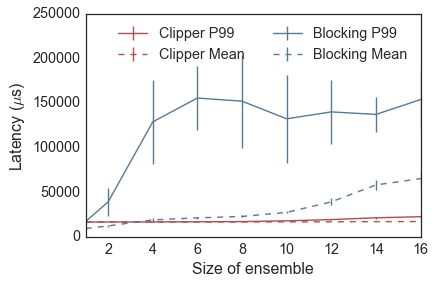

In [102]:
# df.sort_values("ensemble_size", inplace=True)
colors = sns.color_palette("Set1", n_colors=8, desat=.5)

# tgs = df.groupby("ensemble_size")
# tg_errs = df.groupby("ensemble_size").std()



fig, ax = plt.subplots()

def plot_line(cur_col, ax, label, color, ls="-"):
#     cur_col = tgs["clipper_p99"]
    cur_col.plot(y="mean", yerr="std", ax=ax, color=color, ls=ls, label=label)

plot_line(tgs["clipper_p99"], ax, "Clipper P99", colors[0])
plot_line(tgs["clipper_mean_lat"], ax, "Clipper Mean", colors[0], ls="--")
plot_line(tgs["blocking_p99"], ax, "Blocking P99", colors[1])
plot_line(tgs["blocking_mean_lat"], ax, "Blocking Mean", colors[1], ls="--")
    
# ax.plot(x=tgs.index.values, y=tgs["clipper_p99","mean"], yerr=tgs["clipper_p99","std"], kind="scatter", color=colors[0], label = "Clipper P99")
# ax.plot(df["ensemble_size"], df["clipper_mean_lat"], color=colors[0], linestyle="--", label = "Clipper Mean")
# ax.plot(df["ensemble_size"], df["blocking_p99"], color=colors[1], label = "Blocking P99")
# ax.plot(df["ensemble_size"], df["blocking_mean_lat"], color=colors[1], linestyle="--", label = "Blocking Mean")
ax.legend(loc=0, ncol=2)
ax.set_ylim(0, 250000)
# ax.set_yscale("log")
ax.set_ylabel("Latency ($\mu$s)")
ax.set_xlabel("Size of ensemble")

